In [49]:
from torch import nn
import torch

class NNApproximator(nn.Module):
    def __init__(
        self,
        num_inputs: int = 1,
        num_outputs: int = 1,
        num_hidden: int = 1,
        dim_hidden: int = 1,
        act: nn.Module = nn.Tanh(),
    ) -> None:
        """Simple neural network with linear layers and non-linear activation function
        This class is used as universal function approximator for the solution of
        partial differential equations using PINNs
        Args:
            num_inputs (int, optional): The number of input dimensions
            num_outputs (int, optional): The number of outputs of the model, in general is 1
            num_hidden (int, optional): The number of hidden layers in the model
            dim_hidden (int, optional): The number of neurons for each hidden layer
            act (nn.Module, optional): The type of non-linear activation function to be used
        """
        super().__init__()

        self.layer_in = nn.Linear(num_inputs, dim_hidden)
        self.layer_out = nn.Linear(dim_hidden, num_outputs)

        num_middle = num_hidden - 1
        self.middle_layers = nn.ModuleList(
            [nn.Linear(dim_hidden, dim_hidden) for _ in range(num_middle)]
        )
        self.act = act

        self.num_inputs = num_inputs
        self.num_outputs = num_outputs

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        out = self.act(self.layer_in(x))
        for layer in self.middle_layers:
            out = self.act(layer(out))
        return self.layer_out(out)

In [50]:
from functorch import make_functional, grad, vmap

# create the PINN model and make it functional using functorch utilities
model = NNApproximator(1,1,4,10)
fmodel, params = make_functional(model)

def f(x: torch.Tensor, params: torch.Tensor) -> torch.Tensor:
    # only a single element is supported thus unsqueeze must be applied
    # for batching multiple inputs, `vmap` must be used as below
    x_ = x.unsqueeze(0)
    res = fmodel(params, torch.t(x_)).squeeze(0)
    return res

# use `vmap` primitive to allow efficient batching of the input
f_vmap = vmap(f, in_dims=(0, None))

# return function for computing higher order gradients with respect
# to input by simply composing `grad` calls and use again `vmap` for
# efficient batching of the input
dfdx = vmap(grad(f), in_dims=(0, None))
d2fdx2 = vmap(grad(grad(f)), in_dims=(0, None))

e:\Harry\S2MA\thesis\PINN\.conda\lib\site-packages\torch\_functorch\deprecated.py:97: UserWarning: We've integrated functorch into PyTorch. As the final step of the integration, functorch.make_functional is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use torch.func.functional_call instead; see the PyTorch 2.0 release notes and/or the torch.func migration guide for more details https://pytorch.org/docs/master/func.migrating.html
  warn_deprecated('make_functional', 'torch.func.functional_call')
e:\Harry\S2MA\thesis\PINN\.conda\lib\site-packages\torch\_functorch\deprecated.py:58: UserWarning: We've integrated functorch into PyTorch. As the final step of the integration, functorch.vmap is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use torch.vmap instead; see the PyTorch 2.0 release notes and/or the torch.func migration guide for more details https://pytorch.org/docs/master/func.migrating

In [51]:
R = 1.0  # rate of maximum population growth parameterizing the equation
X_BOUNDARY = 0.0  # boundary condition coordinate
F_BOUNDARY = 0.5  # boundary condition value


def loss_fn(params: torch.Tensor, x: torch.Tensor) -> torch.Tensor:

    # interior loss
    f_value = f(x, params)
    interior = dfdx(x, params) - R * f_value * (1 - f_value)

    # boundary loss
    x0 = X_BOUNDARY
    f0 = F_BOUNDARY
    x_boundary = torch.tensor([x0])
    f_boundary = torch.tensor([f0])
    boundary = f(x_boundary, params) - f_boundary

    loss = nn.MSELoss()
    loss_value = loss(interior, torch.zeros_like(interior)) + loss(
        boundary, torch.zeros_like(boundary)
    )

    return loss_value

In [52]:
import torchopt
# choose the configuration
batch_size = 30  # number of colocation points sampled in the domain
num_iter = 100  # maximum number of iterations
learning_rate = 1e-1  # learning rate
domain = (-5.0, 5.0)  # logistic equation domain

# choose optimizer with functional API using functorch
optimizer = torchopt.FuncOptimizer(torchopt.adam(lr=learning_rate))

arr_loss = []
# train the model
for i in range(num_iter):

    # sample colocations points in the domain randomly at each epoch
    x = torch.FloatTensor(batch_size).uniform_(domain[0], domain[1])

    # update the parameters using the functional API
    f = funcs[0]
    dfdx = funcs[1]
    loss_fn = make_loss_fn(f, dfdx)
    # loss = loss_fn(params, x)
    arr_loss.append(float(loss))
    params = optimizer.step(loss, params)

    print(f"Iteration {i} with loss {float(loss)}")

Iteration 0 with loss 0.5759101510047913
Iteration 1 with loss 0.06467712670564651
Iteration 2 with loss 0.3852834701538086
Iteration 3 with loss 0.15453383326530457
Iteration 4 with loss 0.06590596586465836
Iteration 5 with loss 0.1857835054397583
Iteration 6 with loss 0.07668238878250122
Iteration 7 with loss 0.05334743112325668
Iteration 8 with loss 0.07378774881362915
Iteration 9 with loss 0.04973378777503967
Iteration 10 with loss 0.04803457111120224
Iteration 11 with loss 0.07043933123350143
Iteration 12 with loss 0.062368132174015045
Iteration 13 with loss 0.0383162684738636
Iteration 14 with loss 0.04452104866504669
Iteration 15 with loss 0.04959964007139206
Iteration 16 with loss 0.03842008858919144
Iteration 17 with loss 0.015902718529105186
Iteration 18 with loss 0.048633456230163574
Iteration 19 with loss 0.03127813711762428
Iteration 20 with loss 0.027493266388773918
Iteration 21 with loss 0.02370275743305683
Iteration 22 with loss 0.029078099876642227
Iteration 23 with lo

Text(0, 0.5, '$\\phi_{n_{epoch}}$')

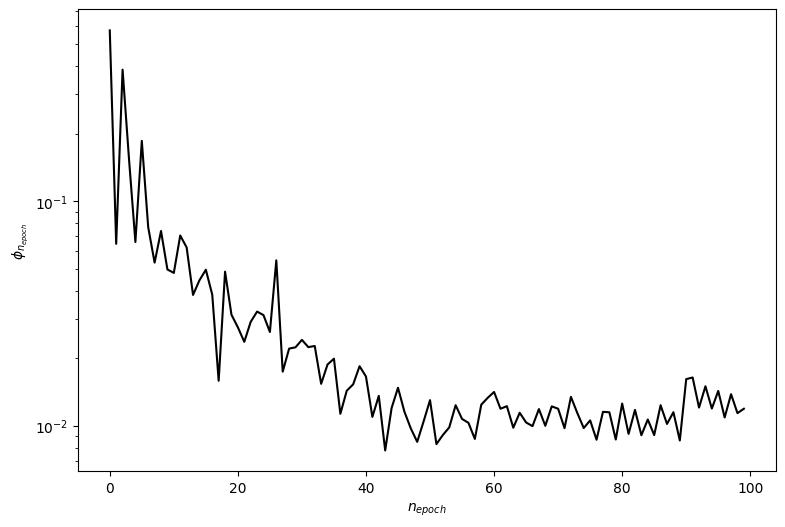

In [53]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(111)
ax.semilogy(range(len(arr_loss)), arr_loss,'k-')
ax.set_xlabel('$n_{epoch}$')
ax.set_ylabel('$\\phi_{n_{epoch}}$')


In [54]:
import numpy as np

N = 100
x_arr = np.linspace(domain[0], domain[1], N).reshape(-1,1)
x = torch.Tensor(x_arr)

upred = fmodel(params, x).squeeze(0).detach().numpy()

In [55]:
u_analitik = 1/(np.exp(-R*x_arr)+1)
u_analitik

array([[0.00669285],
       [0.00739896],
       [0.00817894],
       [0.00904041],
       [0.00999169],
       [0.01104196],
       [0.01220126],
       [0.01348063],
       [0.01489212],
       [0.01644893],
       [0.01816549],
       [0.02005754],
       [0.0221422 ],
       [0.02443814],
       [0.02696557],
       [0.02974643],
       [0.03280439],
       [0.036165  ],
       [0.0398557 ],
       [0.04390588],
       [0.04834692],
       [0.05321217],
       [0.0585369 ],
       [0.06435824],
       [0.07071501],
       [0.07764755],
       [0.0851974 ],
       [0.093407  ],
       [0.1023192 ],
       [0.11197671],
       [0.12242144],
       [0.13369374],
       [0.14583148],
       [0.1588691 ],
       [0.17283646],
       [0.18775769],
       [0.20364993],
       [0.22052213],
       [0.23837374],
       [0.25719365],
       [0.2769591 ],
       [0.29763488],
       [0.31917283],
       [0.34151151],
       [0.36457644],
       [0.38828059],
       [0.41252537],
       [0.437

Text(0, 0.5, '$\\phi_{n_{epoch}}$')

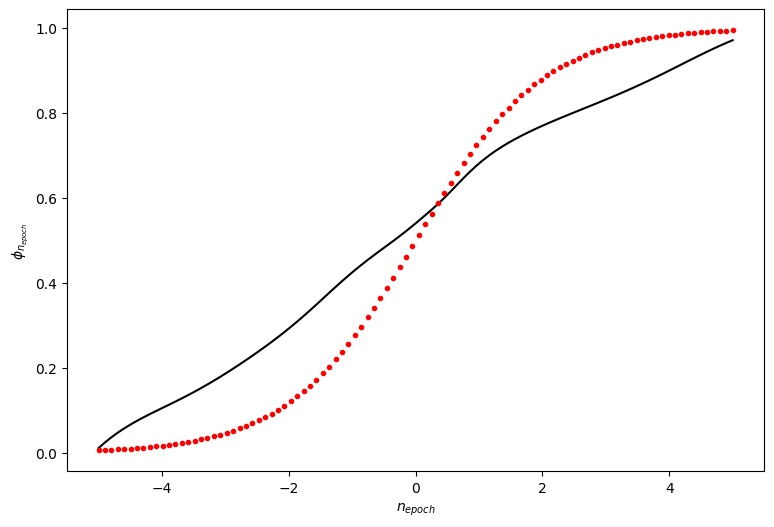

In [56]:
fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(111)
ax.plot(x_arr, upred,'k-')
ax.plot(x_arr, u_analitik,'.r')
ax.set_xlabel('$n_{epoch}$')
ax.set_ylabel('$\\phi_{n_{epoch}}$')

In [57]:
u_analitik

array([[0.00669285],
       [0.00739896],
       [0.00817894],
       [0.00904041],
       [0.00999169],
       [0.01104196],
       [0.01220126],
       [0.01348063],
       [0.01489212],
       [0.01644893],
       [0.01816549],
       [0.02005754],
       [0.0221422 ],
       [0.02443814],
       [0.02696557],
       [0.02974643],
       [0.03280439],
       [0.036165  ],
       [0.0398557 ],
       [0.04390588],
       [0.04834692],
       [0.05321217],
       [0.0585369 ],
       [0.06435824],
       [0.07071501],
       [0.07764755],
       [0.0851974 ],
       [0.093407  ],
       [0.1023192 ],
       [0.11197671],
       [0.12242144],
       [0.13369374],
       [0.14583148],
       [0.1588691 ],
       [0.17283646],
       [0.18775769],
       [0.20364993],
       [0.22052213],
       [0.23837374],
       [0.25719365],
       [0.2769591 ],
       [0.29763488],
       [0.31917283],
       [0.34151151],
       [0.36457644],
       [0.38828059],
       [0.41252537],
       [0.437